In [1]:
import pandas as pd
import numpy as np 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)

tqdm.pandas()

C:\Users\yogas\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\yogas\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [2]:
df = pd.read_csv('D:/big boy college shit/ML/Project/go_emotions_dataset.csv')
df.head(5)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
df.shape

(211225, 31)

In [4]:
emotions = set(df.columns[3:])
emotions

{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

In [5]:
positive = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love','optimism','pride','relief'}
negative = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness','remorse','grief','disgust'}
ambiguous = {'realization','surprise','curiosity','confusion','neutral'}

print(f'Fine grained emotions: {len(emotions)}')
print(f'Number of data: {len(df)}')
print(f'Number of positive emotions: {len(positive)}') 
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')

Fine grained emotions: 28
Number of data: 211225
Number of positive emotions: 12
Number of negative emotions: 11
Number of ambiguous emotions: 5


In [6]:
df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(positive)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(negative)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(ambiguous)] = 'ambiguous'
df_emotion.head(3)

,emotion,group
0,annoyance,negative
1,embarrassment,negative
2,gratitude,positive


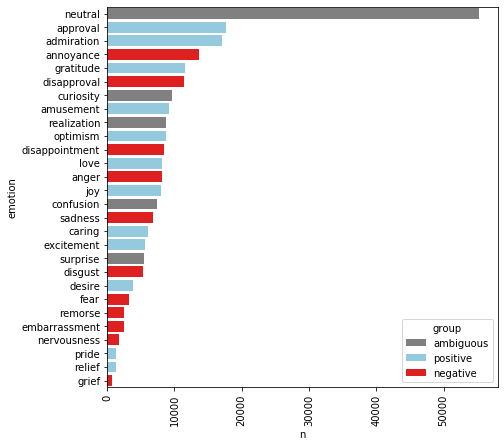

In [7]:
temp = df[emotions].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .merge(df_emotion, how='left', on='emotion')\
    .sort_values('n', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
palette ={
    "positive": "skyblue", 
    "negative": "red", 
    "ambiguous": 'gray'
}
sns.barplot(data=temp, x='n', 
            y='emotion', hue='group', 
            dodge=False,
            palette=palette,
            ax=ax)

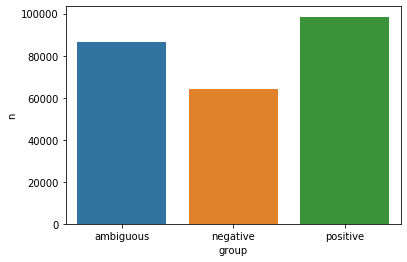

In [8]:
temp = temp.groupby('group') \
        .agg('sum').reset_index()

sns.barplot(data=temp, x='group', y='n')

In [9]:
df_emotion.columns

Index(['emotion', 'group'], dtype='object')

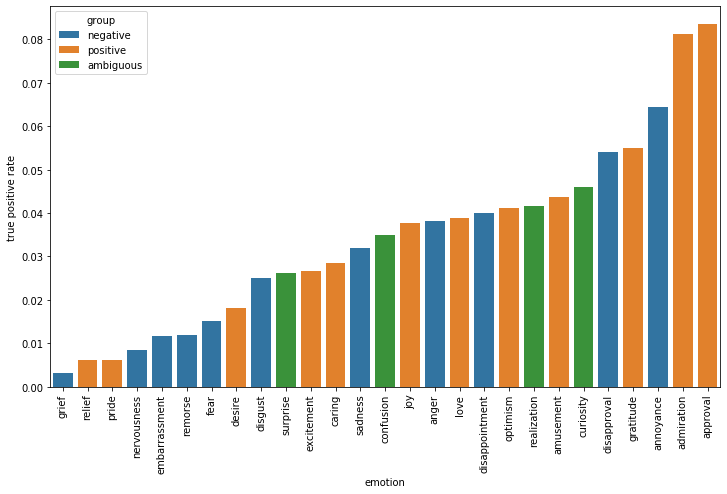

In [10]:
temp = pd.DataFrame()
temp['true positive rate'] = df.iloc[:, 3:-1].mean(0)
temp['emotion'] = df.columns[3:-1]
temp = temp.merge(df_emotion, how='left', on='emotion')
temp = temp.sort_values('true positive rate')

fig, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='x', rotation=90)

sns.barplot(x=temp['emotion'], 
            y=temp['true positive rate'], 
            hue=temp['group'], 
            dodge=False)

In [11]:
!pip install -q preprocessor
!pip install -q contractions

In [12]:
import preprocessor
import contractions

In [13]:
def clean_text(text):
  re_number = re.compile('[0-9]+')
  re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
  re_tag = re.compile('\[[A-Z]+\]')
  re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
  re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
  re_punc = re.compile('[?!,.\'\"]')
  
  text = re.sub(re_char, "", text) # Remove unknown character 
  text = contractions.fix(text) # Expand contraction
  text = re.sub(re_url, ' [url] ', text) # Replace URL with number
  text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
  #text = re.sub(re_punc, "", text) # Remove punctuation.
  text = text.lower() # Lower text
  text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

  return text

In [14]:
data = pd.read_csv('D:/big boy college shit/ML/Project/go_emotions_dataset.csv')

In [15]:
data.head(3)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
data.drop('id', inplace=True, axis=1)
data.drop('example_very_unclear', inplace=True, axis=1)

In [17]:
data["cleaned_text"] = data["text"].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████| 211225/211225 [00:04<00:00, 51628.70it/s]


In [18]:
display(data[['text', 'cleaned_text']].sample(5))

,text,cleaned_text
129545,I wonder if these little creatures with their ...,i wonder if these little creatures with their ...
49597,Are you high? People go for walks while wearin...,are you high? people go for walks while wearin...
1322,This comment is complete garbage.,this comment is complete garbage.
22276,Same here. Around the same time frame. Ill rep...,same here. around the same time frame. ill rep...
57766,Dude I love these,dude i love these


In [19]:
data['emotion'] = (data.iloc[:, 1:] == 1).idxmax(1)
data.head(5)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text,emotion
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,that game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sexuality should not be a grouping category i...,admiration
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"you do right, if you do not care then fuck them!",neutral
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,man i love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"name was nowhere near them, he was by the falc...",neutral


In [20]:
data = data[ ['cleaned_text', 'emotion'] + [ col for col in data.columns if col not in ['text', 'cleaned_text', 'emotion'] ] ]
data = data[data['cleaned_text'] != '']

display(data.head(5))

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt.,sadness,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality should not be a grouping category i...,admiration,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"you do right, if you do not care then fuck them!",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,man i love reddit.,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"name was nowhere near them, he was by the falc...",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
data.shape

(211211, 30)

In [22]:
output_dir = 'D:/big boy college shit/ML/Project/'
train_dataset_path = output_dir + '/train_dataset.csv'
test_dataset_path = output_dir + '/test_dataset.csv'

In [23]:
train, test = train_test_split(data, test_size=0.5, 
                                shuffle=True, random_state=42)

In [24]:
train.to_csv(train_dataset_path, index=None)
test.to_csv(test_dataset_path, index=None)

In [25]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

display(df_train.shape)
display(df_test.shape)

(105605, 30)

(105606, 30)

In [26]:
df_train.head(3)

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,the worst part is that if you had done the exc...,disappointment,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ah yes that makes sense the gofundme for her ...,desire,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,name is not interested in ceremony but is inte...,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
size_train = df_train.shape[0]
size_test = df_test.shape[0]

size_all = size_train + size_test

In [28]:
train_count_GE = (df_train.loc[:, emotions].sum(axis=0) / size_train)*100
test_count_GE = (df_test.loc[:, emotions].sum(axis=0) / size_test)*100

balance_GE = pd.DataFrame(data=[train_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train', 'Test'], value_name='Percentage')

display(balance_GE.head())

,Emotion,Dataset,Percentage
0,neutral,Train,26.187207
1,approval,Train,8.228777
2,admiration,Train,8.130297
3,annoyance,Train,6.423938
4,gratitude,Train,5.664505


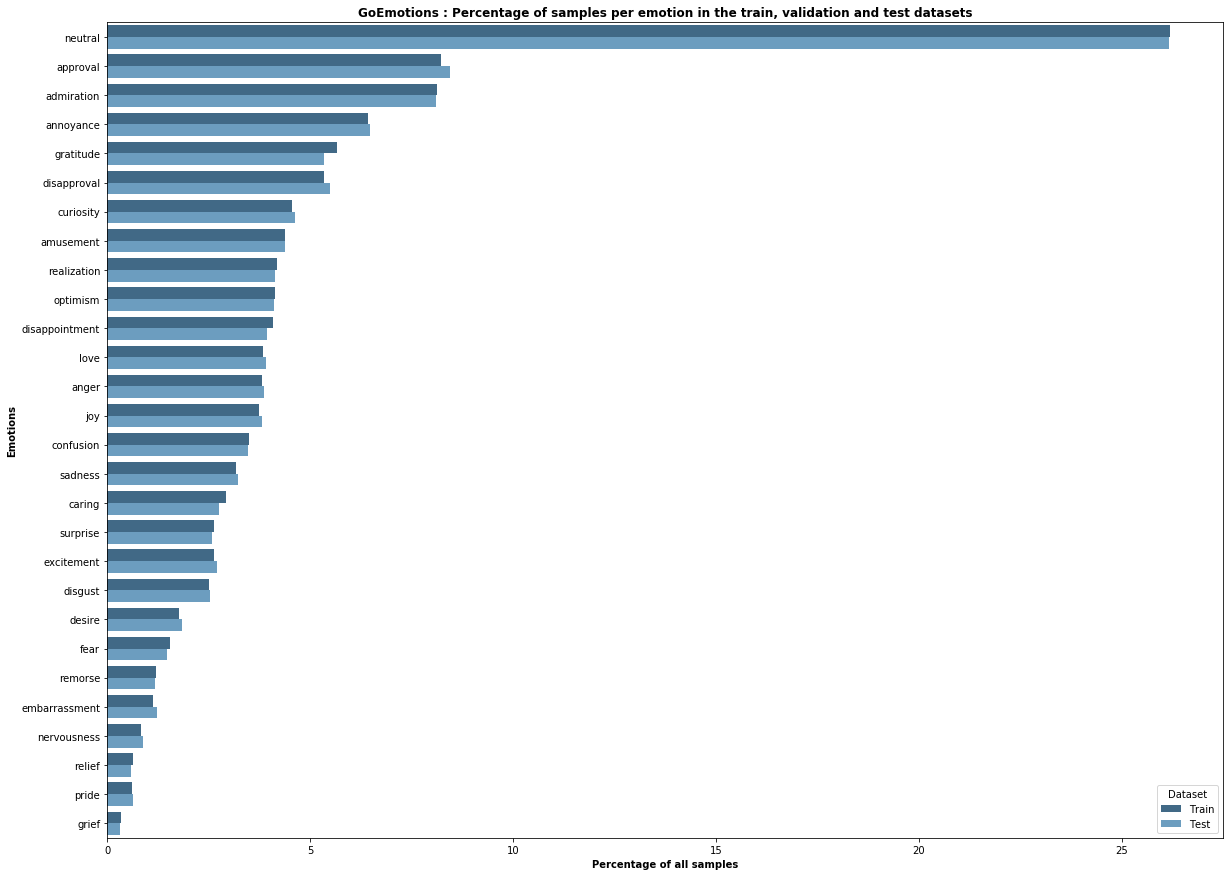

In [29]:
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Blues_d")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

In [30]:
X_train = df_train["cleaned_text"]
y_train = np.asarray(df_train[df_train.columns[2:]])
X_test = df_test["cleaned_text"]
y_test = np.asarray(df_test[df_test.columns[2:]])

In [31]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, max_df=0.85)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.85, max_features=3000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [32]:
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [33]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(class_weight='balanced')
classifier = MultiOutputClassifier(logistic_regression, n_jobs=-1)
classifier.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=1.0,
                                                   class_weight='balanced',
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='warn', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_jobs=-1)

In [34]:
classifier_preds = classifier.predict(X_train_tfidf)
classifier_preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [35]:
emotions = list(emotions)

In [36]:
print("Shape of y_test:", y_test.shape)
print("Shape of classifier_preds:", classifier_preds.shape)


Shape of y_test: (105606, 28)
Shape of classifier_preds: (105605, 28)


In [37]:
y_test = y_test[:classifier_preds.shape[0], :]
test_accuracy = accuracy_score(y_test, classifier_preds)
print('Test accuracy = {}'.format(test_accuracy))

print(classification_report(y_test, classifier_preds, target_names=emotions))

Test accuracy = 0.007082997964111548


C:\Users\yogas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\yogas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


                precision    recall  f1-score   support

     annoyance       0.08      0.20      0.12      8544
 embarrassment       0.04      0.10      0.06      4619
     gratitude       0.04      0.18      0.06      4067
        relief       0.06      0.28      0.10      6834
          fear       0.08      0.33      0.13      8930
           joy       0.03      0.20      0.05      2914
   disapproval       0.03      0.24      0.06      3660
   realization       0.05      0.28      0.08      4884
       sadness       0.02      0.15      0.03      1954
     amusement       0.04      0.28      0.07      4165
disappointment       0.06      0.32      0.09      5789
         anger       0.02      0.16      0.04      2665
        caring       0.01      0.15      0.03      1285
      surprise       0.03      0.20      0.05      2853
     curiosity       0.01      0.08      0.02      1563
         grief       0.05      0.08      0.06      5643
       remorse       0.00      0.07      0.01  

In [38]:
def predict_samples(text_samples, model):

    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(clean_text)
    
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [emotions[i] for i in range(len(x)) if x[i]==1], axis=1)
    
    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [39]:
test_text = df_train.sample(5)
test_text = test_text["cleaned_text"].values.tolist()
predict_samples(test_text, classifier)

,Text,Emotions
0,lol of course its a religion you stoopid carni...,"[embarrassment, fear, joy, sadness, love]"
1,"you should not have been leaving anyway, witch...","[gratitude, fear, realization, sadness, disapp..."
2,i would be creeped out.,[pride]
3,i wake up as a girl everyday. a girl with a pe...,"[gratitude, sadness, anger, surprise, nervousn..."
4,you are going to be pissed.,"[gratitude, relief, realization, remorse]"
